In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import PIL
import glob
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

2024-04-15 12:30:14.308221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:30:14.308343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:30:14.434778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Set TensorFlow to use GPU if available
if tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
    print('GPU is available')
else:
    print('GPU is not available')


GPU is available


In [4]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine the features and the label for the train dataset 
train_df = pd.concat([X_train, y_train], axis=1)
# Load the dataset (fraud and non-fraud data)
fraud_data = train_df[train_df['Class'] == 1].drop('Class', axis=1).values
non_fraud_data = train_df[train_df['Class'] == 0].drop('Class', axis=1).values

# Calculate the number of synthetic fraud samples to generate
num_real_fraud = len(fraud_data)
num_synthetic_samples = len(non_fraud_data) - num_real_fraud
print("# of non-fraud: ", len(non_fraud_data))
print("# of Real Fraud:", num_real_fraud)
print("# of Synthetic Fraud required:", num_synthetic_samples)

# of non-fraud:  225632
# of Real Fraud: 378
# of Synthetic Fraud required: 225254

fraud_data = pd.DataFrame(fraud_data)
fraud_data.head()


# copy the data 
df_max_scaled = fraud_data.copy() 

max_col_values = []

# apply normalization techniques 
for column in df_max_scaled.columns: 
    max_col_values.append(df_max_scaled[column].abs().max())
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max() 
      
# view normalized data 
df_max_scaled.head()
fraud_data = np.array(df_max_scaled)

print(fraud_data.shape)
fraud_data_train = fraud_data[0:350,]
fraud_data_val = fraud_data[350:394,]
print(fraud_data_train.shape)
print(fraud_data_val.shape)

# of non-fraud:  227451
# of Real Fraud: 394
# of Synthetic Fraud required: 227057
(394, 30)
(350, 30)
(44, 30)


In [5]:
print(type(fraud_data_train))

<class 'numpy.ndarray'>


In [6]:
# fraud_data_train = tf.convert_to_tensor(fraud_data_train)
# fraud_data_val = tf.convert_to_tensor(fraud_data_val)

In [7]:
fraud_data_val = np.array(fraud_data_val)
fraud_data_train = np.array(fraud_data_train)
print(type(fraud_data_val))
print(type(fraud_data_train))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
fraud_data_train_ds = tf.data.Dataset.from_tensor_slices(fraud_data_train)
fraud_data_val_ds = tf.data.Dataset.from_tensor_slices(fraud_data_val)


In [26]:
BATCH_SIZE= 64
SHUFFLE= 100
train_dataset= fraud_data_train_ds.shuffle(SHUFFLE).batch(BATCH_SIZE)
test_dataset = fraud_data_val_ds.batch(SHUFFLE)

In [27]:
output_dim = 30
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=(30,))

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [28]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers, input_dim=30):
        super().__init__()

        self.num_coupling_layers = num_coupling_layers
        self.input_dim = input_dim

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(input_dim), scale_diag=tf.ones(input_dim)
        )
        print("input_dim:", input_dim)
        print("num_coupling_layers:", num_coupling_layers)

        self.masks = np.concatenate([np.eye(30)[::-1]] * (num_coupling_layers//2), axis=0)
        print("self.masks.shape:", self.masks.shape)

        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(input_dim) for _ in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.

        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i % len(self.masks)]
            reversed_mask = 1 - self.masks[i % len(self.masks)]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


In [29]:
type(fraud_data_train_ds)
# type(fraud_data_val)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [30]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device:', tf.test.gpu_device_name())
else:
    print("No GPU available. Using CPU instead.")

Default GPU Device: /device:GPU:0


In [31]:
model = RealNVP(num_coupling_layers=20)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001))

with tf.device('/device:GPU:0'):
        history = model.fit(
            train_dataset, batch_size=128, epochs=750, verbose=2, validation_data=test_dataset
         )

input_dim: 30
num_coupling_layers: 20
self.masks.shape: (300, 30)
Epoch 1/750
6/6 - 97s - 16s/step - loss: 28.4738 - val_loss: 28.4006
Epoch 2/750
6/6 - 0s - 25ms/step - loss: 28.4548 - val_loss: 28.3064
Epoch 3/750
6/6 - 0s - 24ms/step - loss: 28.3325 - val_loss: 28.2123
Epoch 4/750
6/6 - 0s - 24ms/step - loss: 28.2338 - val_loss: 28.1184
Epoch 5/750
6/6 - 0s - 23ms/step - loss: 28.1434 - val_loss: 28.0246
Epoch 6/750
6/6 - 0s - 24ms/step - loss: 28.0297 - val_loss: 27.9311
Epoch 7/750
6/6 - 0s - 24ms/step - loss: 27.9471 - val_loss: 27.8374
Epoch 8/750
6/6 - 0s - 23ms/step - loss: 27.8421 - val_loss: 27.7435
Epoch 9/750
6/6 - 0s - 24ms/step - loss: 27.7858 - val_loss: 27.6492
Epoch 10/750
6/6 - 0s - 24ms/step - loss: 27.6570 - val_loss: 27.5546
Epoch 11/750
6/6 - 0s - 23ms/step - loss: 27.5973 - val_loss: 27.4599
Epoch 12/750
6/6 - 0s - 28ms/step - loss: 27.4873 - val_loss: 27.3648
Epoch 13/750
6/6 - 0s - 26ms/step - loss: 27.3821 - val_loss: 27.2695
Epoch 14/750
6/6 - 0s - 29ms/step

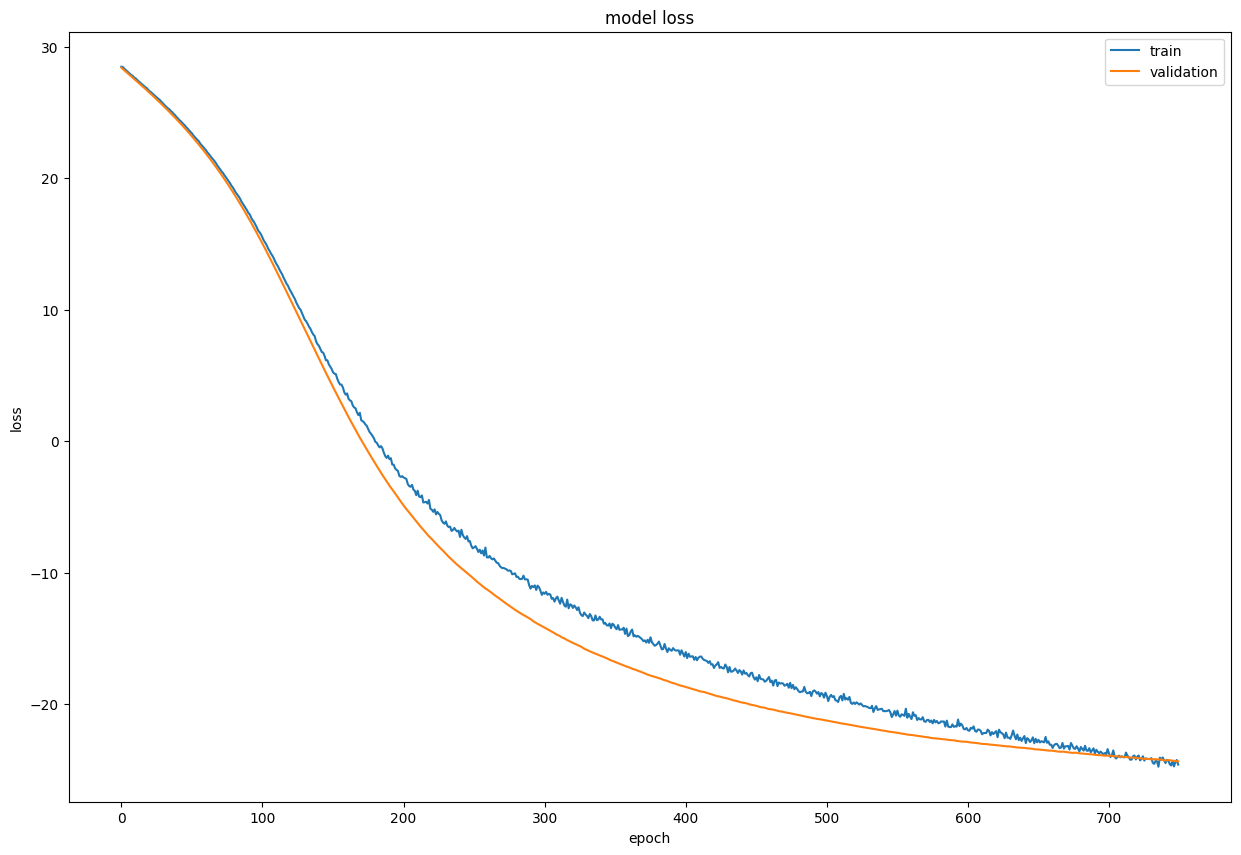

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(fraud_data)

In [33]:
# From latent space to data.
samples = model.distribution.sample(300)
x, _ = model.predict(samples)
(pd.DataFrame(samples).head(10))

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 599ms/step


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-1.155478,0.202346,0.506563,1.853077,-1.118111,2.857128,-0.339795,1.478844,0.886393,-1.383684,...,-1.276067,0.406373,-0.676450,0.707934,-0.056479,0.250071,-0.241523,-2.367758,0.019133,-1.179097
1,-3.200485,-0.086936,-0.349257,1.286375,-2.313617,1.030353,-1.014156,-2.209561,0.559330,0.221265,...,-1.481036,0.290948,-0.014380,-1.803528,0.211407,-0.804444,0.532597,0.388156,-0.644280,-0.237760
2,-0.489067,0.093420,0.880035,0.346857,0.354041,-1.231992,1.501577,1.651027,-0.522974,-1.027816,...,-1.425437,-1.194018,-0.547850,0.779134,0.491145,-0.888491,-0.443462,-1.765273,-0.117704,-1.269306
3,0.706301,-1.266540,0.300476,1.057623,0.009313,-0.195369,-0.814258,0.191894,0.423611,-1.909726,...,-0.268966,2.338715,-0.335894,-1.678282,-0.223345,0.797888,-0.646888,-0.210424,-0.020562,2.046937
4,-2.041626,-0.263491,0.042885,-1.402495,0.012191,2.113193,-0.143055,-0.601902,-3.620760,2.576434,...,1.273355,-0.602732,-0.086666,1.652716,0.539645,-0.616157,-0.376519,-0.530140,-0.256651,-0.481600
5,1.158151,0.403760,1.210100,0.012816,-0.097963,-1.156582,-2.046430,1.363179,-0.968223,1.334164,...,0.858742,0.842748,0.202690,1.479768,0.345201,-1.125291,-0.654837,1.148444,-1.463374,-0.340875
6,-0.813027,1.785157,-1.105038,-1.844788,-0.386764,-0.193803,-0.818674,-0.353090,0.812382,1.298020,...,1.195526,0.262639,1.568152,0.511331,0.840922,-0.644225,-2.567564,-1.081598,-1.047559,2.770068
7,1.706862,-0.873525,-1.246382,0.549557,1.081316,0.373953,-1.812810,-1.934058,-0.815384,-1.399639,...,-0.124394,0.252818,-1.082130,-0.177521,-0.021100,1.358024,0.001587,-1.315272,-0.733407,0.287892
8,-0.061155,-1.227345,0.781592,0.205581,-1.701800,-0.744906,0.043745,-1.635696,1.178411,1.696291,...,2.464970,-0.370683,-0.802480,-0.024301,1.945915,-1.043241,-0.309893,0.190868,1.157095,0.214493
9,-0.420840,0.196616,0.628684,0.529858,0.721637,-1.127378,0.522721,-1.152639,-0.881838,0.718509,...,0.471448,-1.776691,0.986640,1.651705,1.654500,-0.299433,-0.442479,-0.301163,1.079893,0.093639


In [17]:
pd.DataFrame(fraud_data).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.242357,-0.420123,0.298064,-0.411156,0.725258,-0.485088,-0.434582,-0.327129,0.193950,-0.574565,...,-0.055818,0.098500,-0.005326,-0.043470,0.308354,0.026323,0.064702,-0.112574,-0.278731,0.017555
1,0.044327,0.010358,0.172687,-0.180530,0.499184,0.070300,-0.409531,-0.017140,0.001354,-0.199394,...,0.035112,0.007677,-0.057584,-0.030321,-0.108404,0.308422,0.178924,0.071435,0.215337,0.000470
2,0.365963,-0.172417,0.113644,-0.170106,0.403324,-0.151238,-0.169921,-0.133399,0.042061,-0.055774,...,-0.025865,0.028095,0.053253,0.028486,-0.077341,-0.148525,-0.133475,-0.204691,0.362525,0.000517
3,0.327330,-0.196496,-0.178202,-0.000227,0.141537,0.154471,-0.359830,-0.043655,-0.066906,0.066076,...,-0.373287,0.040498,-0.111679,-0.036265,0.068982,-0.042904,-0.172083,0.244425,-0.055788,0.146721
4,0.412509,-0.049506,0.051371,-0.051475,0.232231,-0.120536,-0.047940,-0.034917,0.020782,-0.111395,...,0.112993,0.026829,0.054606,0.029448,0.159557,0.008548,0.300814,0.057064,0.142977,0.149638


In [18]:
print(max_col_values)

[170348.0, 30.552380043581, 22.0577289904909, 31.1036848245812, 12.1146718424589, 22.105531524316, 6.47411462748849, 43.5572415712451, 41.0442609210741, 13.4340663182301, 24.5882624372475, 12.0189131816199, 18.6837146333443, 3.12779501198771, 19.2143254902614, 4.49894467676621, 14.1298545174931, 25.1627993693248, 9.49874592104677, 4.85125513655685, 11.0590042933942, 27.2028391573154, 8.88701714094871, 19.2543276173719, 2.02802422921896, 4.78160552206407, 2.7452606721766, 7.26348214633855, 1.86929047595671, 2125.87]


In [19]:
samples = np.array(samples)

In [20]:
for i in range(samples.shape[0]):
    for j in range(samples.shape[1]):
        samples[i,j] = samples[i,j]*max_col_values[j]

In [21]:
pd.DataFrame(samples).head(10)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,81892.039062,-4.169713,14.589795,-7.358659,-4.778691,10.189742,-2.828671,9.445626,-49.355396,-13.635340,...,-18.423241,29.314159,-12.847509,-11.775401,0.807060,0.617870,-0.868709,-2.805488,-0.394249,1546.543213
1,-150164.781250,32.576054,22.521603,26.126024,9.900797,-25.669523,-0.918548,-28.934353,47.483921,-10.242170,...,20.712751,33.572617,-12.894328,12.768406,3.433872,3.395999,-2.471370,0.777727,0.235545,1087.345459
2,53199.777344,-2.788084,-32.608665,9.313231,-1.356410,-7.972899,-1.047807,-41.460773,-79.266472,34.359287,...,-0.100829,19.842585,16.573769,10.915166,4.213712,-3.025959,-0.048201,-3.887318,-0.481376,-1571.226440
3,-5256.756348,-39.551865,-4.950829,17.077652,-25.481819,4.064002,2.185220,52.365246,24.673422,-0.727777,...,9.522402,-39.541309,12.157608,-31.300964,-0.037850,0.547755,6.007516,-2.168491,-0.890810,2186.650635
4,-400869.031250,14.213334,-15.417003,48.539520,-0.591660,-45.942921,3.490381,4.513725,-38.530327,-2.391616,...,-3.567105,-18.498684,-8.253433,-25.228418,-2.110863,-9.751531,-3.375579,3.476393,-0.847111,2123.815430
5,-70187.320312,33.636463,0.544415,35.859844,15.438334,41.124279,4.056302,6.999313,25.309427,1.882904,...,-23.955252,-43.571297,-0.129418,7.095787,0.722431,0.406032,0.559045,5.345101,1.630250,-3002.821289
6,-292684.937500,22.482027,-1.173883,12.810105,-2.601327,33.592384,3.961782,-21.511108,72.065002,-16.005774,...,-0.747648,-30.520674,7.411683,2.926786,1.304718,-5.473228,-3.793606,-1.730769,-2.454764,-5958.726074
7,80628.390625,-39.744110,24.582901,25.940042,-3.863719,28.905529,3.941783,-39.154678,-33.618526,-1.705638,...,17.438128,50.971813,7.404174,24.377132,-1.465202,-3.846581,-2.741008,-2.620790,1.610370,-1563.952881
8,-108888.367188,-28.423620,-45.739594,-12.527951,-22.272707,-12.820845,3.187408,59.871243,10.421208,6.518192,...,-2.727128,-94.642296,-1.216539,-12.012362,-2.050940,0.744461,-2.256782,1.932379,1.893755,2880.718018
9,220078.796875,17.337744,0.957990,-28.544394,-20.173201,-30.089970,-0.929032,-17.625732,-3.700838,26.733082,...,-11.110120,1.340141,7.440456,10.533041,-1.611599,-0.848452,-1.180036,-1.502462,0.245473,278.985809


In [22]:
pd.DataFrame(samples).to_csv("/kaggle/working/samples.csv",index = False)

In [23]:

pd.DataFrame(fraud_data).to_csv("/kaggle/working/fraud_data.csv",index = False)

In [34]:
model.save("/kaggle/working/NF_model.keras")